# Risk Analysis

The purpose of this section is to combine the CitiBike trip data with the NYC collision data to perform a risk analysis. The goal is two-fold:
1. Get a measure of risky stations
    - This can be used to warn users about to start their ride from a risky station.
    - Making risk salient may make users extra careful when riding and reduce the accident rate.
2. Create a model capable of predicting the risk associated with a ride from a particular station at a particular time.
    - Such a model is helpful for an insurance company to assess risk when providing ride insurance.
    - In turn, this may be integrated into the pricing strategy, so that the insurance pricing can depend on the station and time.

In [ ]:
# Imports
import pandas as pd
import duckdb
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import folium
import branca.colormap as cm


## 1. Risk measure of stations

In [42]:
# Data for station risk measurement
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

con = duckdb.connect("../data/processed/citibike/citibike.duckdb")

stations = con.execute("""
WITH trips AS (
    SELECT
        start_station_id,
        start_station_name,
        start_lat,
        start_lng,
        end_station_id,
        end_station_name,
        end_lat,
        end_lng
    FROM read_parquet($data_path)
),
stations_union AS (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_lat AS lat,
        start_lng AS lon
    FROM trips
    WHERE start_station_id IS NOT NULL
      AND start_lat IS NOT NULL
      AND start_lng IS NOT NULL

    UNION

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_lat AS lat,
        end_lng AS lon
    FROM trips
    WHERE end_station_id IS NOT NULL
      AND end_lat IS NOT NULL
      AND end_lng IS NOT NULL
)
SELECT DISTINCT
    station_id,
    station_name,
    ROUND(lat::DOUBLE, 5) AS lat,
    ROUND(lon::DOUBLE, 5) AS lon
FROM stations_union
ORDER BY station_id
""", {"data_path": DATA_PATH}).df()

collision = pd.read_csv("../data/processed/cleaned_collision_data.csv")
collision["CRASH DATETIME"] = pd.to_datetime(collision["CRASH DATETIME"], errors="coerce")

To obtain a station-level indicator of cyclist crash risk, we combine NYPD collision data with CitiBike station locations and trip data. Using a spatial matching approach based on a Haversine-distance BallTree, we assign each crash to its nearest station within a 300-meter radius and compute a severity-weighted risk score for each location. This procedure produces a measure of relative safety across the CitiBike network.

In [43]:
# Combining crash data with nearest stations using BallTree with Haversine distance

# Prepare station coordinate tree (lat/lon → radians)
stations_rad = np.radians(stations[["lat", "lon"]].values)
tree = BallTree(stations_rad, metric="haversine")

# Query nearest station for each crash
crash_coords_rad = np.radians(collision[["LATITUDE", "LONGITUDE"]].values)
dist, idx = tree.query(crash_coords_rad, k=1)

# Convert radians → meters
dist_m = dist * 6371000  

collision["nearest_station_id"] = stations.iloc[idx.flatten()].station_id.values
collision["distance_m"] = dist_m.flatten()

# Filter only crashes within 300m
df_station = collision[collision["distance_m"] <= 300]

# Calculate severity weight as a weighted sum of cyclist involvement, injuries and fatalities
df_station["severity_weight"] = (
    1 * df_station["CYCLIST_INVOLVED"] +
    5 * df_station["NUMBER OF CYCLIST INJURED"] +
    100 * df_station["NUMBER OF CYCLIST KILLED"]
)

# Aggregate risk per station
risk_raw = (
    df_station.groupby("nearest_station_id")["severity_weight"]
    .sum()
    .reset_index()
    .rename(columns={"severity_weight": "risk_raw"})
)

# Normalize risk to [0, 1]
risk_raw["risk_norm"] = risk_raw["risk_raw"] / risk_raw["risk_raw"].max()

# Merge risk data back to stations
stations_with_risk = stations.merge(risk_raw, how="left", left_on="station_id",
                                    right_on="nearest_station_id")

# Fill NaN risk values with 0
stations_with_risk["risk_raw"] = stations_with_risk["risk_raw"].fillna(0)
stations_with_risk["risk_norm"] = stations_with_risk["risk_norm"].fillna(0)

/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_15472/1327811734.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["severity_weight"] = (


After linking crashes to stations, we translate each incident into a severity score that captures not just the presence of a cyclist but also whether injuries or fatalities occurred. Aggregating these scores at the station level gives a raw measure of crash severity exposure. Because crash events are rare and highly skewed, we normalize these station totals to the [0,1] range to facilitate comparison across the network.

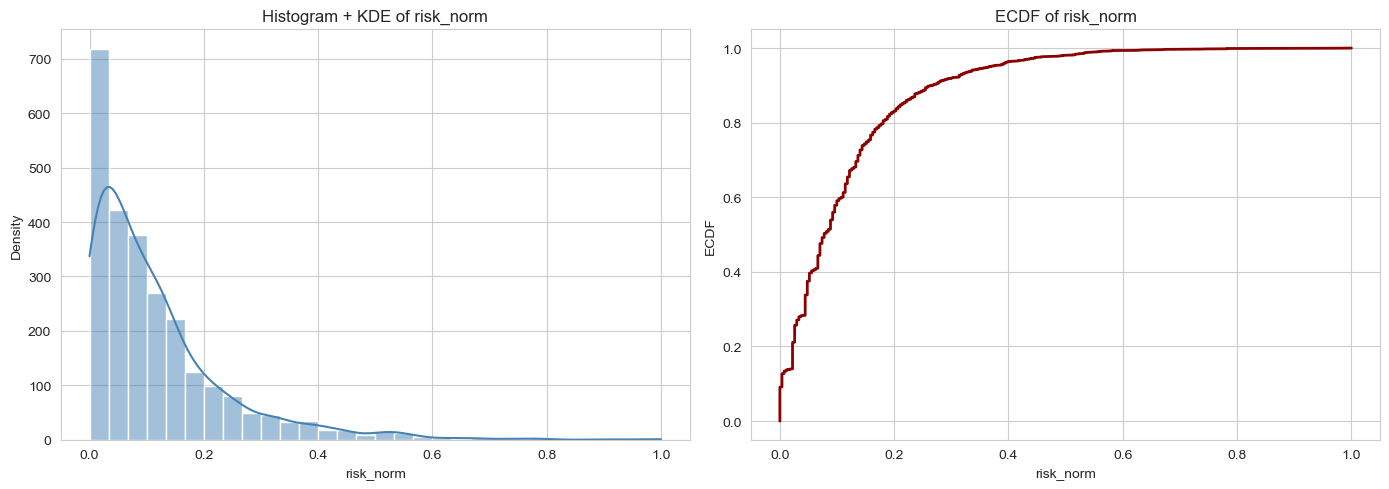

In [44]:
# Visualize the distribution of risk_norm
vals = stations_with_risk["risk_norm"].values


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------------------------------
# LEFT: Histogram + KDE
# --------------------------------------------
sns.histplot(vals, bins=30, kde=True, ax=axes[0], color="steelblue")
axes[0].set_xlabel("risk_norm")
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram + KDE of risk_norm")

# --------------------------------------------
# RIGHT: ECDF
# --------------------------------------------
sorted_vals = np.sort(vals)
ecdf = np.linspace(0, 1, len(sorted_vals))

axes[1].plot(sorted_vals, ecdf, color="darkred", lw=2)
axes[1].set_xlabel("risk_norm")
axes[1].set_ylabel("ECDF")
axes[1].set_title("ECDF of risk_norm")
axes[1].grid(True)

plt.tight_layout()
plt.show()



The resulting distribution of normalized risk scores is heavily right-skewed: most stations experience essentially no cyclist-involved activity, while a small number of stations form a clear upper tail of risk. Plotting both a histogram with a KDE and an empirical CDF reveals that only a small subset of stations contribute meaningfully to the high-risk regions of the city. This suggests that risk is highly localized and that targeted interventions could be more effective than uniform city-wide policies.

In [ ]:
risky_threshold = stations_with_risk["risk_norm"].quantile(0.95)
risky = stations_with_risk.loc[stations_with_risk["risk_norm"] >= risky_threshold].copy()

df = risky  # only the filtered stations

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()
fig = folium.Figure(width="60%", height="450px")
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=12,
               tiles="cartodbpositron")
fig.add_child(m)

MAX_RADIUS = 40
colormap = cm.linear.Reds_09.scale(0, 1)

for _, row in df.iterrows():
    radius = max(MAX_RADIUS * row["risk_norm"], 4)
    color = colormap(row["risk_norm"])
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"risk: {row['risk_norm']:.3f}<br>",
            max_width=250,
        ),
    ).add_to(m)

m


Given the strong concentration of risk in the upper tail, it is natural to focus attention on the highest-risk stations. Using the empirical distribution, we select the top 5% of stations by normalized risk and map them using Folium. These stations represent meaningful safety outliers—locations where cyclist-involved crashes with injuries or fatalities disproportionately occur relative to the rest of the network. Visualizing these hotspots helps reveal geographic patterns associated with known high-traffic corridors, bridge access points, or intersections with heavy vehicle flows.

### Conclusion

This station-level risk score provides a practical foundation for a range of safety-oriented applications. CitiBike could integrate this metric into the rider app to warn users who are about to start trips from historically risky stations or to suggest safer nearby alternatives. Operational teams could use the score to identify stations where infrastructure improvements, clearer signage, or temporary mitigations may yield disproportionate safety benefits. Finally, insurers could rely on the risk score to price micro-insurance products, quantify relative exposure, or support data-driven conversations about liability and rider protection.

Overall, this approach offers a transparent, reproducible, and spatially precise way to translate collision data into actionable insights for both riders and system operators.

## 2. Predictive model of risk